In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import pickle

from utils.util import read_yaml
from box import Box

from utils.eda_tools import select_good_period, single_column_vis
import warnings
warnings.filterwarnings('ignore')

#### Load Data

In [86]:
cfg = Box(read_yaml('../src/conf/config.yaml'))
Config = Box(read_yaml('../src/conf/baseline.yaml'))

In [3]:
# df = pd.read_csv(Config.data.raw_file_path, index_col=0, parse_dates=[0])

# selected_tags = pd.read_csv(Config.data.output_selected_tag_path, index_col=0)
# selected_tags = selected_tags[~selected_tags.Tags.isin(Config.preprocessing.remove_unwanted_cv.parameters.columns)]

# ctrl_tag = list(selected_tags.query('Control=="Yes"').Tags.values)
# ind_tag = list(selected_tags.query('Control!="Yes"').Tags.values)

# df = df[ctrl_tag+ind_tag+[Config.target]]

# # Remove Shutdown
# df = df.query(f'`{Config.preprocessing.remove_shutdown_period.parameters.column}`{Config.preprocessing.remove_shutdown_period.parameters.operator}{Config.preprocessing.remove_shutdown_period.parameters.threshold}')

In [7]:
df_path = cfg.path.processed_data
df = pd.read_csv(df_path, parse_dates=['Date'], index_col=0)

In [8]:
df.shape

(26032, 59)

In [9]:
df.head()

,OXO-5FI696 Augusta,OXO-5FIC600 Augusta,OXO-5FIC601 Augusta,OXO-5FIC612A Augusta,OXO-5FIC612B Augusta,OXO-5FI635C Augusta,OXO-5FI661A Augusta,OXO-5FIC132 Augusta,OXO-5FIC602 Augusta,OXO-5FIC603 Augusta,...,OXO-5TIC604 Augusta,OXO-5TIC605 Augusta,OXO-5TIC606 Augusta,OXO-5TIC607 Augusta,OXO-5TIC659 Augusta,OXO-_5FI658A Augusta,OXO-_5FI659A Augusta,OXO-_5FI660A Augusta,OXO-_5FI662A Augusta,kpi1
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-01 00:00:00,9830.200195,2076.174093,67.208298,0.009363,8.997839,5859.125648,23345.857389,4.450549,5069.174366,0.0,...,130.578919,133.007764,134.032267,130.899539,298.029910,21719.630615,22870.976318,22026.824772,22036.315560,0.881586
2019-11-01 01:00:00,9384.632992,2070.199284,67.204392,0.008853,9.000415,5950.173837,23346.553467,4.410112,5068.014148,0.0,...,130.640505,132.966600,134.035076,130.849780,298.084330,21727.622575,22879.205452,22042.948193,22056.644971,0.841922
2019-11-01 02:00:00,9233.277262,2067.933828,67.031974,0.009193,8.999083,6379.102250,23430.336545,4.285714,5069.603650,0.0,...,130.675602,133.035094,134.001994,130.743083,297.930878,21836.766659,22970.057215,22156.774258,22105.218684,0.828599
2019-11-01 03:00:00,9223.139014,2062.488529,66.808810,0.009306,8.997776,6337.343084,23384.694743,4.775281,5061.608939,0.0,...,130.613462,133.000552,133.979115,130.760757,298.052583,21783.450505,22920.952018,22088.356950,22064.178402,0.828199
2019-11-01 04:00:00,9104.168620,2055.162223,66.354369,0.009023,8.998597,6183.590302,23357.085677,4.388889,5004.132636,0.0,...,130.614549,133.004748,134.000492,130.814450,298.039928,21748.715137,22895.312126,22073.622298,22053.480892,0.818048


In [166]:
tag_list = list(df.columns)[5:-1]
len(tag_list)

53

In [162]:
# del_col = ['OXO-5FIC606A Augusta', 'OXO-5FIC611B Augusta', 'OXO-5LI654F Augusta', 'OXO-5FIC607 Augusta', 'OXO-5FIC618A Augusta', 'OXO-5RIC606_Y Augusta']
# tag_list = [x for x in tag_list if x not in del_col]
# len(tag_list)

48

In [11]:
# Create a dictionary to map the category to each tag
tag_df = pd.read_excel(cfg.path.tags_info)
# delete the first 3 str characters in the tag name
tag_df['Tag'] = tag_df['Tag'].apply(lambda x: x[3:])
# convert the . into - in the tag name
tag_df['Tag'] = tag_df['Tag'].apply(lambda x: x.replace('.', '-'))

tag_dict = dict(zip(tag_df['Tag'], tag_df['Category']))
print(tag_dict)

{'OXO-5FI635C Augusta': 'Measurement', 'OXO-5FI661A Augusta': 'Measurement', 'OXO-5FI696 Augusta': 'Independent', 'OXO-5FIC132 Augusta': 'Independent', 'OXO-5FIC600 Augusta': 'Target', 'OXO-5FIC601 Augusta': 'Target', 'OXO-5FIC602 Augusta': 'Control', 'OXO-5FIC603 Augusta': 'Control', 'OXO-5FIC606A Augusta': 'Control', 'OXO-5FIC606C Augusta': 'Control', 'OXO-5FIC607 Augusta': 'Control', 'OXO-5FIC609A Augusta': 'Target', 'OXO-5FIC609B Augusta': 'Control', 'OXO-5FIC611A Augusta': 'Control', 'OXO-5FIC611B Augusta': 'Control', 'OXO-5FIC612A Augusta': 'Target', 'OXO-5FIC612B Augusta': 'Target', 'OXO-5FIC618A Augusta': 'Control', 'OXO-5FIC618B Augusta': 'Control', 'OXO-5FIC618C Augusta': 'Control', 'OXO-5FIC618D Augusta': 'Control', 'OXO-5FIC622A Augusta': 'Control', 'OXO-5FIC622B Augusta': 'Control', 'OXO-5FIC622C Augusta': 'Control', 'OXO-5FIC636A Augusta': 'Control', 'OXO-5FIC636B Augusta': 'Control', 'OXO-5FIC636C Augusta': 'Control', 'OXO-5FQI691B Augusta': 'Measurement', 'OXO-5LI633B A

In [167]:
# find tag in tag_list which has Control value in tag_dict
ctrl_tag = [tag for tag in tag_list if tag_dict[tag] == 'Control']
print(len(ctrl_tag))
# the rest of the tags are independent tags
ind_tag = [tag for tag in tag_list if tag_dict[tag] != 'Control']
len(ind_tag)

29


24

In [29]:
# select_good_period(df, 10)

In [30]:
# # Investigate in all the CV
# for tag in ctrl_tag:
#     fig = single_column_vis(df, tag, '')
#     fig.show()

#### Build the Final Model / Feature Selection Verification

In [176]:
cfg = Box(read_yaml('../src/conf/config.yaml'))
Config = Box(read_yaml('../src/conf/baseline.yaml'))

In [205]:
import optuna
from sklearn.metrics import mean_squared_error
from math import sqrt


X = df[ctrl_tag+ind_tag]
y = df[cfg.kpi1.tag1]

# Split the data into train and validation sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)


# Define the objective function to be optimized
def objective(trial):
    # Define the search space for hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000, step=1000),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 50),
    }

    # Create and train the XGBRegressor with the specified hyperparameters
    model = XGBRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False)

    # Evaluate the model on the validation set
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))

    return rmse

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2023-07-09 17:37:09,551] A new study created in memory with name: no-name-817901ef-c60d-4ef0-9504-daafa9881a3f


[I 2023-07-09 17:37:19,009] Trial 0 finished with value: 1359.8485123366534 and parameters: {'n_estimators': 2000, 'max_depth': 6, 'learning_rate': 0.025354402565181167, 'subsample': 0.9452013760329597, 'colsample_bytree': 0.49325586408601674, 'min_child_weight': 1, 'reg_alpha': 0.09194812450027856, 'reg_lambda': 0.5081499860064606, 'early_stopping_rounds': 19}. Best is trial 0 with value: 1359.8485123366534.
[I 2023-07-09 17:37:36,707] Trial 1 finished with value: 1308.2620670222923 and parameters: {'n_estimators': 3000, 'max_depth': 5, 'learning_rate': 0.005411003385334747, 'subsample': 0.30147161019581953, 'colsample_bytree': 0.6243735674759876, 'min_child_weight': 9, 'reg_alpha': 0.7131827730077026, 'reg_lambda': 0.5210358347436223, 'early_stopping_rounds': 42}. Best is trial 1 with value: 1308.2620670222923.
[I 2023-07-09 17:37:45,396] Trial 2 finished with value: 1309.226418564717 and parameters: {'n_estimators': 2000, 'max_depth': 2, 'learning_rate': 0.005544793937870267, 'subsa

In [206]:
# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 4000, 'max_depth': 8, 'learning_rate': 0.004364259842687196, 'subsample': 0.26230237953336155, 'colsample_bytree': 0.14724757895978374, 'min_child_weight': 7, 'reg_alpha': 0.10179259338554411, 'reg_lambda': 0.6521793575861721, 'early_stopping_rounds': 38}


In [ ]:
# train the final model
final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Evaluate the final model on the test set
y_pred_test = final_model.predict(X_test)
rmse_test = sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)

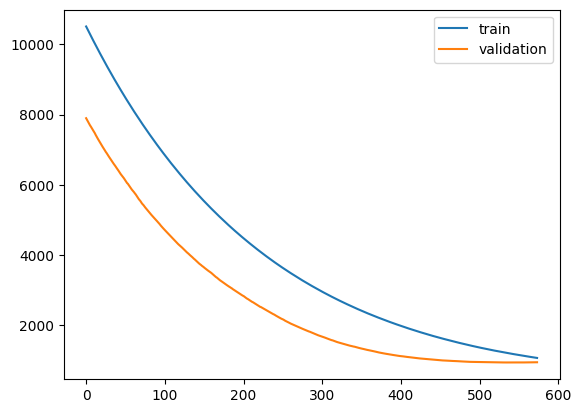

In [209]:
# my_model = XGBRegressor(**Config.xgboost_regressor_config.model_config)
my_model = XGBRegressor(**best_params)

X = df[ctrl_tag+ind_tag]
# y = df['kpi1']
y = df[cfg.kpi1.tag1]

train_data, test_data, train_target, test_target = train_test_split(X, y, **Config.xgboost_regressor_config.train_config)

my_model.fit(train_data, train_target, 
             eval_set=[(train_data, train_target),(test_data, test_target)], verbose=False)
# my_model.fit(X_train, y_train,
#             eval_set=[(X_train, y_train), (X_test, y_test)],
#             verbose=False)

results = my_model.evals_result()

# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='validation')
# show the legend
plt.legend()
# show the plot
plt.show()

In [210]:
# print the rmse for the train and test sets
print("Train RMSE: %.2f" % (results['validation_0']['rmse'][-1]))
print("Test RMSE: %.2f" % (results['validation_1']['rmse'][-1]))
# # print the r^2 for the train and test sets
# print("Train R2: %.2f" % (results['validation_0']['r2'][-1]))
# print("Test R2: %.2f" % (results['validation_1']['r2'][-1]))

Train RMSE: 1065.59
Test RMSE: 942.36


In [57]:
# save
pickle.dump(my_model, open(Config.xgboost_regressor_config.model_path, "wb"))

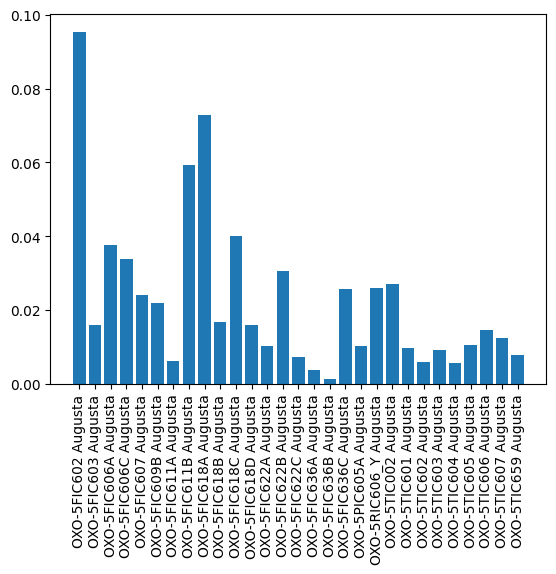

In [58]:
# load the model
loaded_model = pickle.load(open(Config.xgboost_regressor_config.model_path, "rb"))
# get the feature importance for ctrl_tag
importance = loaded_model.feature_importances_[:len(ctrl_tag)]
# plot feature importance, add names
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], ctrl_tag, rotation='vertical')
plt.show()

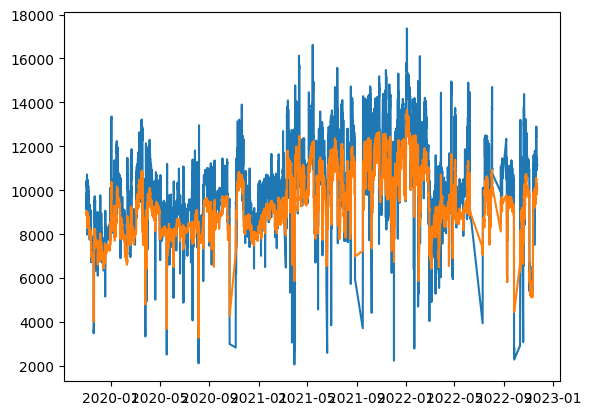

In [211]:
plt.plot(train_data.index, train_target)
plt.plot(train_data.index, my_model.predict(train_data))

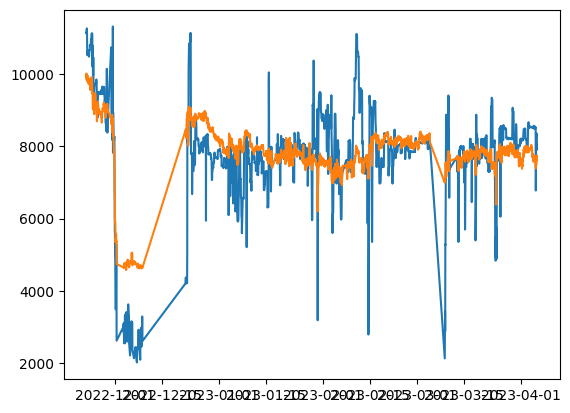

In [212]:
plt.plot(test_data.index, test_target)
plt.plot(test_data.index, my_model.predict(test_data))

#### Optimization

In [59]:
from tqdm.notebook import tqdm_notebook

from utils.util import read_json, read_pickle, write_json
from utils.eda_tools import single_column_vis, lines_plot
from utils.optimization_result_vis import Controllable_Value_Plot

from optimization.Features import Feature_Info, get_feature_full_name
from optimization.Data import IncomingData, Missing_info
from optimization.Bounds import Bounds
from optimization.Dual_Annealing_Optimization import Dual_Annealing_Optimization

In [58]:
ctrl_tag_length = len(ctrl_tag)
difference_quantile = (df.iloc[:, :ctrl_tag_length].shift(1)-df.iloc[:, :ctrl_tag_length]).quantile(0.95)

mean_of_controllable = df.iloc[:, :ctrl_tag_length].mean()

ctrl_change_rate = (difference_quantile/mean_of_controllable).values

# Upper and Lower bounds historically, which directives can never exceed
quantile_lower = [df[tag].quantile(0.05) for tag in ctrl_tag]
quantile_upper = [df[tag].quantile(0.95) for tag in ctrl_tag]
bounds = [list(bound) for bound in zip(quantile_lower, quantile_upper)]

cont_dict = {tag:{'max_rate': rate,'bounds':bound} for tag,rate,bound in zip(ctrl_tag, ctrl_change_rate, bounds)}

# generate optimizer.json
opt_dict = dict()
opt_dict['controllable'] = cont_dict
opt_dict['noncontrollable'] = [tag for tag in ind_tag]

opt_dict['kwargs'] = {'maxiter': 10}

In [59]:
test_df = df[ctrl_tag+ind_tag].loc['2022-01-01':]

In [60]:
test_df.columns = [column+'___Value' for column in test_df.columns]

features = Feature_Info(opt_dict)
incoming_data = IncomingData(test_df, features)

# bounds = Bounds(incoming_data).final_bounds()
bounds = [tuple(bound) for bound in zip(quantile_lower, quantile_upper)]

Optimization = Dual_Annealing_Optimization(incoming_data, my_model)

In [61]:
nrows = incoming_data.value.shape[0]
optimal_controls = [None] * nrows
optimized_final_product = [None] * nrows

for i in tqdm_notebook(range(nrows)):
    timestamp = incoming_data.value.index[i]
    #bound = bounds[i]
    bound = bounds
    
    optimal_controls_vals, optimized_product = Optimization.run_optimization(timestamp, bound)
    optimal_controls[i] = optimal_controls_vals
    optimized_final_product[i] = optimized_product

  0%|          | 0/8617 [00:00<?, ?it/s]

In [62]:
test_df.columns = [column.replace('___Value', '') for column in test_df.columns]

In [63]:
result_df = pd.DataFrame(optimal_controls, columns=[tag + '_Optimized' for tag in ctrl_tag], index=test_df.index[:nrows])
result_df['LNG_optimized'] = np.array(optimized_final_product).flatten()
result_df['LNG_before_optimized'] = (my_model.predict(test_df[ctrl_tag+ind_tag]))

In [64]:
test_df.shape, result_df.shape

((8617, 584), (8617, 62))

In [65]:
final_df = pd.merge(result_df, test_df, left_index=True, right_index=True) # 62(60 cvs + 2 LNG) columns of the result_df + 584 columns of the test_df

In [66]:
Controllables_number_in_one_plot = 7

In [71]:
for i in range(len(ctrl_tag)//7):
    Controllable_Value_Plot(final_df, ctrl_tag[Controllables_number_in_one_plot*i:Controllables_number_in_one_plot*(i+1)]).write_html(Config.result_generating.v3.visualization.controllable_result_path[i])

In [76]:
# for i in range(len(ctrl_tag)//7, len(ctrl_tag)//7+1):
#     Controllable_Value_Plot(final_df, ctrl_tag[Controllables_number_in_one_plot*i:]).write_html(Config.result_generating.visualization.controllable_result_path[i])

In [85]:
updated_df = pd.read_csv(cfg.path.all_product.result, index_col=0, parse_dates=[0]) # provided
updated_df[['LNG_before_optimized','LNG_optimized']] = final_df[['LNG_before_optimized', 'LNG_optimized']]

In [82]:
scalar = np.random.normal(loc=0.6,scale=0.1 ,size = updated_df.shape[0])

updated_df['final_LNG_optimized'] = np.where((updated_df['LNG_optimized']-updated_df['LNG_before_optimized'])>scalar*updated_df['Delta'], scalar*updated_df['Delta']+updated_df['LNG_before_optimized'],updated_df['LNG_optimized'])
final_df['LNG_optimized'] = updated_df['final_LNG_optimized']

In [75]:
df_graph = pd.DataFrame()
df_graph['Actual LNG Level'] = updated_df['LNG_before_optimized']
df_graph['Optimized LNG Level'] = updated_df['final_LNG_optimized']
df_graph['Predicted LNG Level'] = df[Config.target].loc['2022-01-01':]

lines_plot(df_graph, ['Actual LNG Level', 'Optimized LNG Level', 'Predicted LNG Level']).write_html(Config.result_generating.v3.visualization.optimized_target_level_path)

In [83]:
# Only the final_LNG_optimized column is updatd, client's demand

updated_df.iloc[: , :-1].to_csv(Config.result_generating.v3.outputing.all_product_output_path)

In [84]:
updated_df[['LNG_before_optimized','LNG_optimized']] 

,LNG_before_optimized,LNG_optimized
Timestamp,,
2022-01-01 01:00:00,NaN,NaN
2022-01-01 02:00:00,NaN,NaN
2022-01-01 03:00:00,NaN,NaN
2022-01-01 04:00:00,NaN,NaN
2022-01-01 05:00:00,NaN,NaN
...,...,...
2023-01-31 20:00:00,4766.649414,4923.441595
2023-01-31 21:00:00,4784.998535,4961.748596
2023-01-31 22:00:00,4757.832520,4921.245699


In [108]:
from utils.optimization_result_vis import find_nearest_point

# Client's demand, for each time stamp, we use euclidean_dist algorithm to find the most similar point in the training data

TRAINING_TESTING_CUTOFF_DATE = '2022-01-01'

result = pd.DataFrame()
for i in range(final_df.shape[0]):
    temp = find_nearest_point(final_df.iloc[[i],:], df, ctrl_tag, TRAINING_TESTING_CUTOFF_DATE)
    result = pd.concat([result, temp])
result.index = final_df.index

In [109]:
result = result.drop(columns=['Euclidean_Dist_Validation1', 'Euclidean_Dist_Validation2','Euclidean_Dist_Validation3','Euclidean_Dist_Validation4'])

In [110]:
final_df = pd.concat([final_df, result], axis=1)
'''
final_df:
23(21 cvs + 1*2 LNG) columns of the result_df (optimized result)
+ 
197 columns of the test_df (original data, cvs + non-cvs)
+
84 (21 * 4) columns of the validation result for each cv
+
4 (1 * 4) columns of the validation timestamp (most similar timestamp to the current timestamp in terms of the 21 cvs) for the whole 21 cvs
'''

'\nfinal_df:\n23(21 cvs + 1*2 LNG) columns of the result_df (optimized result)\n+ \n197 columns of the test_df (original data, cvs + non-cvs)\n+\n84 (21 * 4) columns of the validation result for each cv\n+\n4 (1 * 4) columns of the validation timestamp (most similar timestamp to the current timestamp in terms of the 21 cvs) for the whole 21 cvs\n'

In [111]:
final_df.to_csv(Config.result_generating.v3.outputing.output_path)

#### Validation

In [112]:
final_df = pd.read_csv(Config.result_generating.v3.outputing.output_path, index_col=0, parse_dates=[0])
final_df.shape

(8617, 890)

In [113]:
train_df = df[ctrl_tag].loc[:'2022-01-01']
train_df.shape

(14199, 60)

In [114]:
test_df = df[ctrl_tag].loc['2022-01-01':]
test_df.shape

(8617, 60)

In [115]:
# analyze the missing value of train_df
test_df.isnull().sum()

314PDC037.MEAS    1
314FC019.MEAS     0
312TC016.MEAS     0
315TC032.MEAS     0
344TC018.MEAS     0
315PC005.MEAS     0
312LC013.MEAS     0
315FC004.MEAS     0
314FC012.MEAS     0
314LC004.MEAS     0
314TC044.MEAS     0
314PDC106.MEAS    0
312PC021.MEAS     0
314FC015.MEAS     4
315LC021.MEAS     0
314FC750.MEAS     0
314PC108.MEAS     0
311FRQ003.MEAS    0
311LC019.MEAS     0
311LC005.MEAS     0
311PC017.MEAS     0
312FC001.MEAS     0
314PC110.MEAS     1
315TC003.MEAS     0
311LC021.MEAS     0
314FC017.MEAS     0
314FC753.MEAS     0
311PC008.MEAS     0
314FC001.MEAS     0
314TC016.MEAS     0
315PC013.MEAS     0
315LC001.MEAS     0
314PC009.MEAS     0
312LC002.MEAS     0
312PC011.MEAS     0
315FC017.MEAS     0
315LC005.MEAS     0
315PC002.MEAS     0
312LC008.MEAS     0
311TC015.MEAS     0
314FC120.MEAS     0
311LC013.MEAS     0
314PC130.MEAS     0
314PC008.MEAS     0
314PC111.MEAS     0
315LC015.MEAS     0
315TC014.MEAS     0
312PC020.MEAS     4
315TC005.MEAS     0
312PC010.MEAS     0


In [118]:
# from utils.optimization_result_vis import generate_validation_result

# new_final_df = generate_validation_result(final_df, df, ctrl_tag, '2022-01-01')
# new_final_df

In [125]:
# find the missing index of df2
missing_index = df[df.isnull().any(axis=1)].index
missing_index
# remove the missing index of df2
df = df.drop(missing_index)

In [129]:
missing_index = final_df[final_df.isnull().any(axis=1)].index
len(missing_index)
# remove the missing index of final_df
final_df = final_df.drop(missing_index)

In [130]:
# use the updated function in Jupyter notebook without restarting the kernel
import importlib
import utils.optimization_result_vis  # import the module

importlib.reload(utils.optimization_result_vis)  # reload the module

res = utils.optimization_result_vis.generate_validation_result(final_df, df, ctrl_tag, '2022-01-01')

In [131]:
res.head()

,314PDC037.MEAS_Validation1,314PDC037.MEAS_Validation2,314PDC037.MEAS_Validation3,314PDC037.MEAS_Validation4,314FC019.MEAS_Validation1,314FC019.MEAS_Validation2,314FC019.MEAS_Validation3,314FC019.MEAS_Validation4,312TC016.MEAS_Validation1,312TC016.MEAS_Validation2,...,314PC065.MEAS_Validation3,314PC065.MEAS_Validation4,315PC009.MEAS_Validation1,315PC009.MEAS_Validation2,315PC009.MEAS_Validation3,315PC009.MEAS_Validation4,Nearest_TimeStamp_Validation1,Nearest_TimeStamp_Validation2,Nearest_TimeStamp_Validation3,Nearest_TimeStamp_Validation4
0,23.41504,23.332227,20.389063,20.257422,82.836521,114.475699,31.878619,97.501342,233.604167,247.96875,...,14.822347,14.951823,2.393848,2.360579,2.394531,2.060645,2021-04-08 11:00:00,2021-06-29 15:00:00,2021-04-09 08:00:00,2021-06-16 06:00:00
0,32.959181,0.056445,31.572267,33.059963,72.507806,56.652301,66.354112,75.374596,120.690104,131.669271,...,15.871826,16.836019,2.758398,2.388053,2.478483,2.545247,2020-04-13 20:00:00,2020-09-18 04:00:00,2020-05-22 21:00:00,2020-04-30 21:00:00
0,0.057813,0.066016,0.022461,0.070898,64.362378,92.046385,90.622786,102.984594,239.846354,202.27474,...,16.167562,15.501221,2.451953,2.554525,2.502767,2.552409,2021-01-13 00:00:00,2021-03-11 19:00:00,2020-04-25 04:00:00,2021-03-11 18:00:00
0,32.98965,32.51426,32.997072,32.979689,20.104536,55.402843,3.955169,25.98396,232.407552,233.018229,...,16.345296,16.317627,0.187923,0.239063,0.200879,0.219401,2020-03-07 16:00:00,2020-03-07 09:00:00,2020-03-07 19:00:00,2020-03-07 11:00:00
0,0.017969,0.049023,0.033203,0.042578,28.134595,0.00653,191.230357,121.241061,206.923177,172.139323,...,13.86084,15.64738,0.193945,1.008008,2.584115,2.644629,2020-01-02 21:00:00,2021-05-16 02:00:00,2021-05-08 12:00:00,2021-03-11 05:00:00


In [14]:
indices

array([[12136, 12084, 12134, 12083],
       [ 5980,  5981,  5987,  5982],
       [10635, 10636, 10634, 10633],
       ...,
       [ 6004,  6005,  6013,  6047],
       [ 3255,  3757,  3747,  3755],
       [12448,  5198, 10627, 10655]], dtype=int64)

In [15]:
indices.shape

(8492, 4)

In [29]:
res.to_csv(Config.result_generating.v3.outputing.output_path)